# Titanic Survivor Dataset Prediction

# TODO
- exploit Cabin and Ticket & age feature instead of dropping
- balance class with oversampling

In [69]:
import pandas as pd
import seaborn as sns
import numpy as np
from sklearn import preprocessing
import torch                                        # root package
from torch.utils.data import Dataset, DataLoader    # dataset representation and loading
import torch.nn as nn                     # neural networks
import torch.nn.functional as F           # layers, activations and more
import torch.optim as optim               # optimizers e.g. gradient descent, ADAM, etc.
from torchvision import datasets, models, transforms     # vision datasets,
                                                         # architectures &
                                                         # transforms
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import accuracy_score

In [5]:
%%javascript
var rate = 0;
// apply setting to  all current CodeMirror instances
IPython.notebook.get_cells().map(
    function(c) {  return c.code_mirror.options.cursorBlinkRate=rate;  }
);

// make sure new CodeMirror instance also use this setting
CodeMirror.defaults.cursorBlinkRate=rate;

<IPython.core.display.Javascript object>

# Data Cleaning

In [117]:
df = pd.read_csv("data/train.csv")
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [118]:
df = df.drop(["Cabin", "Ticket", "Name", "PassengerId"], axis = 1)

In [119]:
df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,male,22.0,1,0,7.2500,S
1,1,1,female,38.0,1,0,71.2833,C
2,1,3,female,26.0,0,0,7.9250,S
3,1,1,female,35.0,1,0,53.1000,S
4,0,3,male,35.0,0,0,8.0500,S


C:\Users\Paul\miniconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Embarked', ylabel='count'>

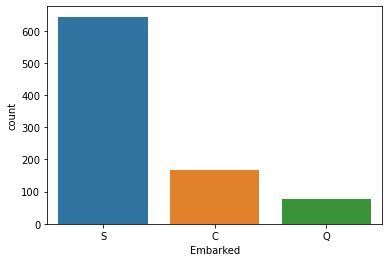

In [120]:
sns.countplot("Embarked", data = df)

In [121]:
df = pd.get_dummies(df, columns = ["Embarked"])
le = preprocessing.LabelEncoder()
df["Sex"] = le.fit_transform(df["Sex"])
df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked_C,Embarked_Q,Embarked_S
0,0,3,1,22.0,1,0,7.2500,0,0,1
1,1,1,0,38.0,1,0,71.2833,1,0,0
2,1,3,0,26.0,0,0,7.9250,0,0,1
3,1,1,0,35.0,1,0,53.1000,0,0,1
4,0,3,1,35.0,0,0,8.0500,0,0,1


In [122]:
df.isnull().sum()

Survived        0
Pclass          0
Sex             0
Age           177
SibSp           0
Parch           0
Fare            0
Embarked_C      0
Embarked_Q      0
Embarked_S      0
dtype: int64

In [123]:
df = df.fillna(df.mean())
#df = df.dropna()
#df = df.reset_index()
#df = df.drop("index", axis = 1)
df.isnull().sum()

Survived      0
Pclass        0
Sex           0
Age           0
SibSp         0
Parch         0
Fare          0
Embarked_C    0
Embarked_Q    0
Embarked_S    0
dtype: int64

In [124]:
df["family_size"] = df["SibSp"] + df["Parch"]

# 2.a) Train a deep neural network

In [125]:
def clean_df(df):
    df = df.drop(["Cabin", "Ticket", "Name", "PassengerId"], axis = 1)
    df = pd.get_dummies(df, columns = ["Embarked"])
    le = preprocessing.LabelEncoder()
    df["Sex"] = le.fit_transform(df["Sex"])
    df = df.fillna(df.mean())
    df["family_size"] = df["SibSp"] + df["Parch"]
    return df

In [126]:
class TitanicData(Dataset):
    def __init__(self, df):
        self.df = df
        self.mean = None
        self.std = None
    
    def __getitem__(self, idx):
        features = self.df.loc[idx].drop("Survived")
        label = self.df.loc[idx, "Survived"]
        
        features = torch.tensor(features).float()
        label = torch.tensor(label).float()
        
        if self.mean != None:
            features = (features - mean) / std
        
        
        return features, label
    
    def __len__(self):
        return len(self.df)
    
    def set_normalization(self, mean, std):
        self.mean = mean
        self.std = std
        

In [127]:
batch_size = 64
train_dataset = TitanicData(df)

# split into training and validation data
size_data = len(train_dataset)
train_data, val_data = torch.utils.data.random_split(train_dataset, (size_data - 100, 100))

test_df = pd.read_csv("data/test.csv")
test_df = clean_df(test_df)

train_loader = DataLoader(train_data, batch_size = batch_size, shuffle = True)
val_loader = DataLoader(val_data, batch_size = len(val_data), shuffle = True)

X_test = torch.tensor(test_df.values).float()

In [331]:
# get the mean and std of each feature
def get_mean_std(dataloader):
    features, labels = next(iter(dataloader))
    mean = features.mean(dim = 0, keepdim = True)
    std = features.std(dim = 0, keepdim = True)
    return mean, std
    
mean, std = get_mean_std(train_loader)
train_dataset.set_normalization(mean, std)

In [368]:
class TitanicModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(9, 40)
        self.fc2 = nn.Linear(40, 15)
        self.fc3 = nn.Linear(15, 1)
        
        self.drop1 = nn.Dropout(p = 0.1, inplace = False)
        self.drop2 = nn.Dropout(p = 0.5, inplace = False)
        self.drop3 = nn.Dropout(p = 0.5, inplace = False)
    
    def forward(self, x):
        x = self.drop1(x)
        x = F.relu(self.fc1(x))
        x = self.drop2(x)
        x = F.relu(self.fc2(x))
        x = self.drop3(x)
        x = F.sigmoid(self.fc3(x))
        return x
    
model = TitanicModel()

In [369]:
opt = optim.Adam(model.parameters(), lr = 0.01)
criterion = nn.BCELoss()

In [370]:
nb_epochs = 20

for epoch in range(nb_epochs):
    print(f"--------- epoch n°{epoch + 1}/{nb_epochs} ------------")
    sum_train_loss = 0
    sum_val_loss = 0
    for b, batch in enumerate(train_loader):
        features, labels = batch
        
        # zero grad
        opt.zero_grad()
        
        # pass batch through model
        output = model(features).squeeze()
        
        # get loss
        loss = criterion(output, labels)
        
        # backpropagate
        loss.backward()
        
        # optimize
        opt.step()
        
        
        sum_train_loss += loss.item()
        model.eval()
        with torch.no_grad():
            val_features, val_labels = next(iter(val_loader))
            val_output = model(val_features).squeeze()
            val_loss = criterion(val_output, val_labels)
            sum_val_loss += val_loss.item()
        model.train()
        
        sum_train_loss += loss.item()
        
        
    print(f"train loss is {sum_train_loss / batch_size}")
    print(f"val loss is   {sum_val_loss / batch_size}")
    

--------- epoch n°1/20 ------------
train loss is 0.2011335026472807
val loss is   0.09430141560733318
--------- epoch n°2/20 ------------
train loss is 0.18184872809797525
val loss is   0.07616296829655766
--------- epoch n°3/20 ------------
train loss is 0.17512533906847239
val loss is   0.07075492618605494
--------- epoch n°4/20 ------------
train loss is 0.16147837787866592
val loss is   0.0689821639098227
--------- epoch n°5/20 ------------
train loss is 0.15638237074017525
val loss is   0.06989415735006332
--------- epoch n°6/20 ------------
train loss is 0.15429047588258982
val loss is   0.06943621532991529
--------- epoch n°7/20 ------------
train loss is 0.15937875676900148
val loss is   0.06753378361463547
--------- epoch n°8/20 ------------
train loss is 0.1570489415898919
val loss is   0.0689264489337802
--------- epoch n°9/20 ------------
train loss is 0.14888566359877586
val loss is   0.06817848049104214
--------- epoch n°10/20 ------------
train loss is 0.153878826647996

In [371]:
model.eval()
with torch.no_grad():
    
    out = model(X_test)
    out = (out > 0.5).int()
    
    out_df = pd.read_csv("data/gender_submission.csv")
    
    
    out_np = out.numpy().reshape(-1)
    out_df["Survived"] = pd.Series(out_np)
    
    out_df.to_csv("data/test_submission.csv", index = False)
    


In [133]:
k = 10
kf = StratifiedKFold(n_splits = k, random_state = None, shuffle = True)
rf = RandomForestClassifier(n_estimators = 1000)
X, y = df.drop("Survived", axis = 1), df["Survived"]

rf.fit(X, y)

#metrics = cross_val_score(rf, X, y, cv = kf, verbose = 2, n_jobs = 4)
#print("mean performance is ", metrics.mean())

RandomForestClassifier(n_estimators=1000)

In [134]:
out_df = pd.read_csv("data/gender_submission.csv")

X_test = clean_df(pd.read_csv("data/test.csv"))

predictions = rf.predict(X_test)
out_df["Survived"] = pd.Series(predictions)

out_df.to_csv("data/test_submission.csv", index = False)